<a href="https://colab.research.google.com/github/calde97/Deep_Learning_Challenge/blob/main/third_challenge/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive 
import os
import json
drive.mount('/content/drive')
%cd /content/drive/MyDrive/challenge3/

Mounted at /content/drive
/content/drive/MyDrive/challenge3


In [ ]:
!unzip /content/drive/MyDrive/anndl-2020-vqa.zip -d /content/
#After downloading the data in /content, we return to the right folder for the entire process
%cd /content/drive/MyDrive/challenge3/

The files will be on /content

# Dataset Creation

Folder structure in Drive

    -challenge3/DS/ 
                 - VQA_Dataset/
                     - test_questions.json
                     - train_questions_annotations.json    
    - ~ 
      - Images/
          -0.png,...,n.png







The images are on Colab root in order to reduce the latency when retrieving the images from drive to the colab ram during the training process.

## Utils for labels dictionary
This is the dict that maps the answers to integers

In [ ]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

## Utils for the creation of the DS

In [ ]:
'''
Args: 
-The dictionary created by loading the json file.
-Dictionary that maps answer string to numbers
Return: 
-3 lists containing the questions, the image names 
and the encoded answers. 
'''
def get_lists_from_data(training_annotations_map, labels_dict):
  ids = []
  questions = []
  image_names = []
  encoded_answers = []

  for value in training_annotations_map.values():
    questions.append(value['question'])
    image_names.append(value['image_id'])
    answer = value['answer']
    encoded = labels_dict.get(answer)
    encoded_answers.append(encoded)

  return questions, image_names, encoded_answers

#Load the json file
def load_json(json_path_name):
  with open(json_path_name) as f:
    data = json.load(f)
  return data

#Not used. Could be useful in the future
def get_ids(training_annotation_string):
  ids = []
  for key in training_annotation_string.keys():
    ids.append(key)
  return ids

In [ ]:
def one_hot_encoding(index, len):
  one_hot = np.zeros(len)
  one_hot[index] = 1
  return one_hot

## Utils for Tokenizing the questions
The max length of a sentence is 21<br>
The unique words are 4640<br>

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

'''
We need to create the tokenizer with the whole ds.
get_tokenizer_whole_data returns the tokenizer on the whole ds
and return the max number of words in all the sentences.
'''

#It takes all the questions
def get_tokenizer_whole_data(questions, max_words=50000):
  tokenizer = Tokenizer(num_words=max_words)
  tokenizer.fit_on_texts(questions)

  tokenized_sentences = tokenizer.texts_to_sequences(questions)
  max_length_sentence = max(len(word) for word in tokenized_sentences)

  return tokenizer, max_length_sentence

'''
We tokenize the questions(usually here we have a subset of all the questions). 
We use the tokenizer created above
'''
#It can take subset of the questions (for training and validation)
def tokenize_input(questions=None, max_length_sentence=None, tokenizer=None):
  tokenized_sentences = tokenizer.texts_to_sequences(questions)
  text_inputs = pad_sequences(tokenized_sentences, maxlen=max_length_sentence)
  return text_inputs

The reason behind the division of the token process in 2 parts is the following: we need to create the tokenizer with all the sentences. Because we want to have a map for all the words in all sentences. We also want to have the max number of words per each sentence for all the sentences. Just think that you tokenize for a small subset of the questions and by chance you have all the sentences of 3 words. Your max length will be 3 but in the whole DS you have sentences with 21 words. That can cause great problems during training and inference

## Creation of the Custom DS

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split

'''
It creates the Dataset.

Args:
data => the data loaded from the json file
labels_dict => dictionary of string answers to integers
all the others are trivial

Returns:
(Input Map, target_classes)
The images in the input map are numpy tensors of (h, w, 3)
The tokenized questions on the input map are vectors of (21,) integers
The target classes are one-hot encoded. Vector of (58,) binary integers

The input map contains the vector of the images and the vector of the 
tokenized questions. 
From a point of view of the model fitting everything should be transparent.
'''

class CustomDataset(tf.keras.utils.Sequence):

  def __init__(self, 
               data = None,
               labels_dict = None, 
               images_path = None,
               subset = 'training', 
               preprocessing_function=None, 
               out_shape=[200, 350],
               seed=1234,
               test_size=0.15):
    
    self.images_path = images_path
    self.subset = subset
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.data = data
    self.test_size = test_size
   
    #Get the questions, images and answers from data
    questions, image_names, answers = get_lists_from_data(data, labels_dict)

    #We need the tokenizer for the questions. We get also the max length of every sentence
    self.tokenizer, self.max_length_sentence = get_tokenizer_whole_data(questions)

    #Split in training and validation
    train_questions, val_questions = train_test_split(questions, test_size=self.test_size, random_state=seed)
    train_image_names, val_image_names = train_test_split(image_names, test_size=self.test_size, random_state=seed)
    train_answers, val_answers = train_test_split(answers, test_size=self.test_size, random_state=seed)
    
    if (subset == 'training'):
      self.image_names = train_image_names
      self.questions = train_questions
      self.answers = train_answers
    else:
      self.image_names = val_image_names
      self.questions = val_questions
      self.answers = val_answers

    #We tokenize the subset of the questions(training or validation). We used the tokenizer created before with the whole ds
    self.tokenized_questions = tokenize_input(questions=self.questions, tokenizer=self.tokenizer, max_length_sentence=self.max_length_sentence)

  def __len__(self):
    return len(self.questions)

  def __getitem__(self, index):
  
    #Reading image
    #We need to convert to RGB since the png has a 4-th transparency channel
    image = Image.open(os.path.join(self.images_path, self.image_names[index] + '.png')).convert('RGB')
    image = image.resize(self.out_shape)
    image_array = np.array(image)

    if self.preprocessing_function is not None:
        image_array = self.preprocessing_function(image_array)

    #Reading the question
    question = self.tokenized_questions[index]

    #Reading the answer
    target = self.answers[index]
    encoded_target = one_hot_encoding(target, 58) #58 is the number of answers we have

    #The inputs are returned as a map. The output is unique
    return {'image':image_array, 'text':question}, encoded_target

In [ ]:
def normalize(img):
  return img / 255.

## Lets create the Dataset 

In [ ]:
json_path = '/content/drive/MyDrive/challenge3/VQA_Dataset/train_questions_annotations.json'
images_path = '/content/VQA_Dataset/Images'

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
data = load_json(json_path)
ds = CustomDataset(data=data, images_path=images_path, labels_dict=labels_dict, subset='training', test_size=0.15, out_shape=[224, 224], preprocessing_function=preprocess_input)

In [ ]:
bs = 128
img_height = 224
img_width = 224
n_classes = 58
train_dataset = tf.data.Dataset.from_generator(lambda: ds,
                                               output_types=({'image':tf.float32, 'text':tf.float32}, tf.float32),
                                               output_shapes=({'image':[img_height, img_width, 3], 'text':[21,]}, [58,] ))
 
train_dataset = train_dataset.batch(bs)
 
train_dataset = train_dataset.repeat()  

In [ ]:
ds_val = CustomDataset(data=data, images_path=images_path, labels_dict=labels_dict, subset='validation', test_size=0.15, out_shape=[224, 224], preprocessing_function=preprocess_input)

In [ ]:
bs = 128
img_height = 224
img_width = 224
n_classes = 58
val_dataset = tf.data.Dataset.from_generator(lambda: ds_val,
                                               output_types=({'image':tf.float32, 'text':tf.float32}, tf.float32),
                                               output_shapes=({'image':[img_height, img_width, 3], 'text':[21,]}, [58,] ))

 
val_dataset = val_dataset.batch(bs)
 
val_dataset = val_dataset.repeat()  

# Model

## Model creation 

We used the MobileNet v2 to get the features of our images. We removed the classifier and added a GAP to reduce the dimensions before the Dense layer. 

In [ ]:
from tensorflow.keras.applications import MobileNetV2

mobile = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
mobile.trainable = False
input = mobile.input
output = mobile.output

old = mobile(input, training=False)

gap = tf.keras.layers.GlobalAveragePooling2D()(old)
dense = tf.keras.layers.Dense(units=256, activation='relu')(gap)

mobile = tf.keras.models.Model(input, dense)

In [ ]:
mobile.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               327936    
Total params: 2,585,920
Trainable params: 327,936
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
import tensorflow as tf
 
img_h = 224
img_w = 224
rnn_input_len = 21
max_words = 4640
EMBEDDING_SIZE = 256
 
# Import Keras 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

 
image_input = Input(shape=(img_h, img_w, 3), name='image')
encoded_image = mobile(image_input)
 
# Define RNN for language input
question_input = Input(shape=(rnn_input_len,), name='text')
#Important the +1 to count the 0 
embedded_question = Embedding(input_dim=max_words + 1, output_dim=EMBEDDING_SIZE, input_length=rnn_input_len)(question_input)
encoded_question = LSTM(EMBEDDING_SIZE,dropout=0.25)(embedded_question)

# Combine CNN and RNN to create the final model
merged = tf.keras.layers.multiply([encoded_question, encoded_image])
hidden = tf.keras.layers.Dense(units=128, activation='relu')(merged)
output = Dense(58, activation='softmax')(hidden)
vqa_model = Model(inputs=[image_input, question_input], outputs=output)

In [ ]:
vqa_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 256)      1188096     text[0][0]                       
__________________________________________________________________________________________________
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          525312      embedding_1[0][0]                
____________________________________________________________________________________________

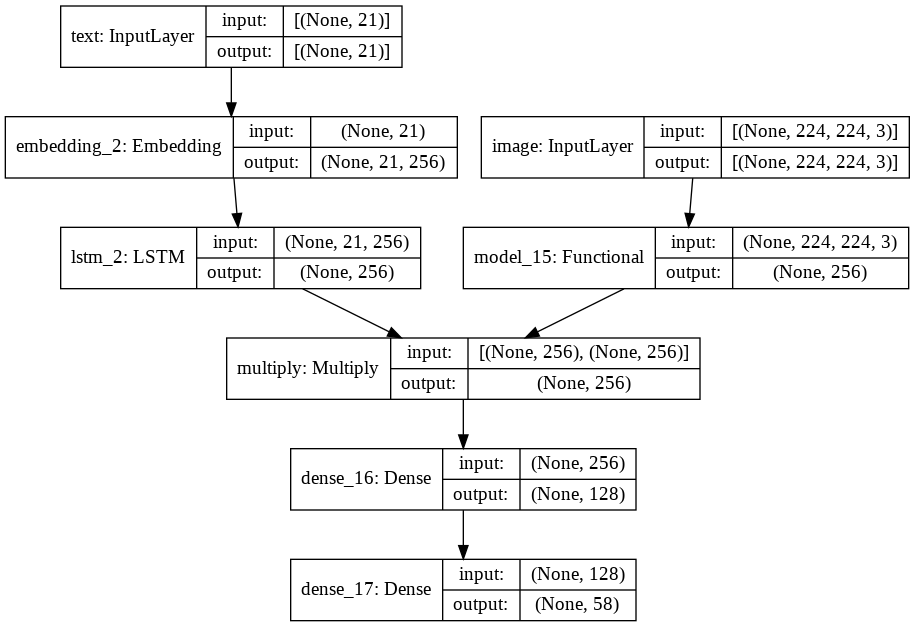

In [ ]:
plot_model(vqa_model, show_shapes=True)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training

In [ ]:
import os
from datetime import datetime


exps_dir = 'multiplication'
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'GAP'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max') 
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)



# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [ ]:
#Trained on bs = 4 

vqa_model.fit(train_dataset,
          epochs=100,
          batch_size=bs, 
          steps_per_epoch=len(ds) // bs,
          validation_data=val_dataset,
          validation_steps=len(ds_val) // bs,
          callbacks=callbacks)m

#/content/drive/MyDrive/challenge3/multiplication/GAP_Jan27_14-26-37

Epoch 1/100
12501/12501 [==============================] - 951s 76ms/step - loss: 1.4660 - accuracy: 0.4668 - val_loss: 1.0299 - val_accuracy: 0.5853
Epoch 2/100
12501/12501 [==============================] - 917s 73ms/step - loss: 0.9754 - accuracy: 0.6056 - val_loss: 1.0086 - val_accuracy: 0.6088
Epoch 3/100
12501/12501 [==============================] - 991s 79ms/step - loss: 0.8679 - accuracy: 0.6463 - val_loss: 1.0165 - val_accuracy: 0.6098
Epoch 4/100
12501/12501 [==============================] - 1053s 84ms/step - loss: 0.7998 - accuracy: 0.6752 - val_loss: 1.0988 - val_accuracy: 0.6022
Epoch 5/100
12501/12501 [==============================] - 1041s 83ms/step - loss: 0.7498 - accuracy: 0.6964 - val_loss: 1.1547 - val_accuracy: 0.6043
Epoch 6/100
12501/12501 [==============================] - 1041s 83ms/step - loss: 0.7110 - accuracy: 0.7124 - val_loss: 1.2357 - val_accuracy: 0.6080
Epoch 7/100
12501/12501 [==============================] - 966s 77ms/step - loss: 0.6787 - accura

In [ ]:
vqa_model.load_weights('/content/drive/MyDrive/challenge3/multiplication/GAP_Jan27_14-26-37/ckpts/cp_02.ckpt') 

In [ ]:
#Multiplication with mobile net and 256 embedding; Trained with higher batch size 128
#It starts from the 2nd epoch of the first training 
vqa_model.fit(train_dataset,
          epochs=100,
          batch_size=bs, 
          steps_per_epoch=len(ds) // bs,
          validation_data=val_dataset,
          validation_steps=len(ds_val) // bs,
          callbacks=callbacks)

Epoch 1/100
390/390 [==============================] - 693s 2s/step - loss: 0.7661 - accuracy: 0.6843 - val_loss: 0.9502 - val_accuracy: 0.6264
Epoch 2/100
390/390 [==============================] - 662s 2s/step - loss: 0.7189 - accuracy: 0.6992 - val_loss: 0.9484 - val_accuracy: 0.6305
Epoch 3/100
390/390 [==============================] - 669s 2s/step - loss: 0.6892 - accuracy: 0.7121 - val_loss: 0.9545 - val_accuracy: 0.6341
Epoch 4/100
390/390 [==============================] - 659s 2s/step - loss: 0.6626 - accuracy: 0.7219 - val_loss: 0.9576 - val_accuracy: 0.6325
Epoch 5/100
390/390 [==============================] - 664s 2s/step - loss: 0.6360 - accuracy: 0.7351 - val_loss: 0.9744 - val_accuracy: 0.6338
Epoch 6/100
228/390 [================>.............] - ETA: 3:53 - loss: 0.6324 - accuracy: 0.7366

KeyboardInterrupt: ignored

In [ ]:
#Multiplication con mobile net e embedding a 256;  with higher batch size 128
#Started from zero 

vqa_model.fit(train_dataset,
          epochs=100,
          batch_size=bs, 
          steps_per_epoch=len(ds) // bs,
          validation_data=val_dataset,
          validation_steps=len(ds_val) // bs,
          callbacks=callbacks)

Epoch 1/100
390/390 [==============================] - 804s 2s/step - loss: 2.0000 - accuracy: 0.4050 - val_loss: 1.0416 - val_accuracy: 0.5825
Epoch 2/100
390/390 [==============================] - 766s 2s/step - loss: 0.9958 - accuracy: 0.5971 - val_loss: 0.9515 - val_accuracy: 0.6075
Epoch 3/100
390/390 [==============================] - 765s 2s/step - loss: 0.8678 - accuracy: 0.6424 - val_loss: 0.9317 - val_accuracy: 0.6141
Epoch 4/100
390/390 [==============================] - 764s 2s/step - loss: 0.7941 - accuracy: 0.6719 - val_loss: 0.9308 - val_accuracy: 0.6255
Epoch 5/100
390/390 [==============================] - 764s 2s/step - loss: 0.7409 - accuracy: 0.6938 - val_loss: 0.9330 - val_accuracy: 0.6265
Epoch 6/100
390/390 [==============================] - 763s 2s/step - loss: 0.7001 - accuracy: 0.7092 - val_loss: 0.9434 - val_accuracy: 0.6299
Epoch 7/100
390/390 [==============================] - 765s 2s/step - loss: 0.6651 - accuracy: 0.7246 - val_loss: 0.9766 - val_accuracy:

## Take prediciton and create dictionary

Define the function that helps us to retrieve the questions and image_names by the annotations loaded from the json file

In [ ]:
# Given test_annotations_map, it returns a the questions and the associated image ids

def get_lists_from_data_test(test_annotations_map):
  ids = []
  questions = []
  image_names = []


  for value in test_annotations_map.values():
    questions.append(value['question'])
    image_names.append(value['image_id'])


  return questions, image_names

Define our custom dataset for the test

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split

'''
It creates the Dataset.

Args:
data => the data loaded from the json file
data_test => the data loaded from the test json file
labels_dict => dictionary of string answers to integers
all the others are trivial

Returns:
(Input Map)
The images in the input map are numpy tensors of (h, w, 3)
The tokenized questions on the input map are vectors of (21,) integers

The input map contains the vector of the images and the vector of the 
tokenized questions. 
'''

class CustomDatasetTest(tf.keras.utils.Sequence):

  def __init__(self, 
               data = None,data_test = None,
               labels_dict = None, 
               images_path = None,
               preprocessing_function=None, 
               out_shape=[200, 350]):
    
    self.images_path = images_path
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.data = data
   
    #Now let's get the tokenizer for the whole data (this is the reason because I take also the data_training)
    #Get the questions, images and answers from data (training)
    questions, image_names, answers = get_lists_from_data(data, labels_dict)

    #We need the tokenizer for the questions. We get also the max length of every sentence
    self.tokenizer, self.max_length_sentence = get_tokenizer_whole_data(questions)

    #Get questions and images_ids from data test
    questions_test, image_names_test = get_lists_from_data_test(data_test)

    self.questions = questions_test
    self.image_names = image_names_test
    #Tokenize the subset of the questions (in the test set)

    self.tokenized_questions = tokenize_input(questions=self.questions, tokenizer=self.tokenizer, max_length_sentence=self.max_length_sentence)



  def __len__(self):
    return len(self.questions)

  def __getitem__(self, index):
  
    #Reading image
    #We need to convert to RGB since the png has a 4-th transparency channel
    image = Image.open(os.path.join(self.images_path, self.image_names[index] + '.png')).convert('RGB')
    image = image.resize(self.out_shape)
    image_array = np.array(image)

    if self.preprocessing_function is not None:
        image_array = self.preprocessing_function(image_array)

    #Reading the question
    question = self.tokenized_questions[index]

    return {'image':image_array, 'text':question}

Let's load all the data we need

In [ ]:
# Note: data is not loaded here because it was loaded before the training

test_json_path = '/content/drive/MyDrive/challenge3/VQA_Dataset/test_questions.json'
images_path = '/content/VQA_Dataset/Images'

data_test = load_json(test_json_path)

In [ ]:
test = CustomDatasetTest(data=data,data_test=data_test,labels_dict = labels_dict,images_path = images_path,out_shape=[224, 224],preprocessing_function=preprocess_input)

In [ ]:
test_dataset = tf.data.Dataset.from_generator(lambda: test,
                                               output_types=({'image':tf.float32, 'text':tf.float32}),
                                               output_shapes=({'image':[img_height, img_width, 3], 'text':[21,]}))

In [ ]:
test_dataset = test_dataset.batch(1)

Let's load the weigths of our model and compute the predictions

In [ ]:
#vqa_model.load_weights("/content/drive/My Drive/challenge3/checkpoints/mod")

In [ ]:
# Compute predictions
predictions = vqa_model.predict(test_dataset)

Create a new function -> takes in input the keys of the label dict and the predictions and create the dictionary {'question_id' : answer_id}

In [ ]:
!pwd

/content/drive/MyDrive/challenge3


In [ ]:
import numpy as np
def create_dictionary(question_ids, predictions):
  res_dict = {}

  for question_id,prediction in zip(question_ids,predictions):
      index = np.argmax(prediction)
      res_dict[question_id] = index
    
  return res_dict
  

In [ ]:
question_ids = list(data_test.keys())
res_dict = create_dictionary(question_ids,predictions)

## Write CSV

In [ ]:
import os
from datetime import datetime

#Kindly provided by MatteoMatteucci
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
create_csv(res_dict)